In [ ]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-5bc90a01-e20e-0ae2-ca02-45e351d7ed05)


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-901aad7f-0c59-3c9e-e5a0-3b63ca7858ef)


Fine-tuning RoBERTa by Huggingface for Fake News classification. 

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.0MB 9.9MB/s 
     |████████████████████████████████| 3.2MB 40.3MB/s 
     |████████████████████████████████| 890kB 37.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=15f1f6e4cca4a454df6cc9ddd279c7a72271da92bdfd7853ed39e79e11a43a65
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 1.2MB 11.3MB/s 


In [ ]:
!ls drive/MyDrive/Study/NewsClassification

image_model_1617038551.pth  model_1616882222.pth
image_model_1617038615.pth  model_1616882540.pth
image_model_1617038680.pth  model_1616882859.pth
image_model_1617038745.pth  model_1616883176.pth
image_model_1617038809.pth  model_1616883494.pth
image_model_1617042056.pth  model_1616883812.pth
image_model_1617045194.pth  model_1616884130.pth
image_model_1617048331.pth  model_1616884448.pth
image_model_1617054602.pth  model_1616884765.pth
images			    model_1617102072.pth
images.zip		    model_1617102131.pth
model_1616870196.pth	    model_1617107538.pth
model_1616870898.pth	    model_1617112818.pth
model_1616871599.pth	    model.pth
model_1616872300.pth	    news1.csv
model_1616873001.pth	    prepared_test.csv
model_1616873702.pth	    prep_news.csv
model_1616874403.pth	    submission_1616887871.9875803.csv
model_1616875103.pth	    submission_1616888253.583158.csv
model_1616875805.pth	    submission_1616888839.701382.csv
model_1616876506.pth	    submission_1616889112.7632372.csv
model_1616

In [ ]:
data_path = 'drive/MyDrive/Study/NewsClassification'
output_path = 'drive/MyDrive/Study/NewsClassification'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import time
import torch
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from torch.autograd import Variable
from transformers import XLNetTokenizer, XLNetModel, XLNetConfig
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [ ]:
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlnet_tokenizer = XLNetTokenizer(tokenizer.vocab_file)

In [ ]:
xlnet_tokenizer("Міністри Зеленського")

{'input_ids': [135866, 88, 111674, 11187, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 2], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [ ]:
MAX_SEQ_LEN = 512
BATCH_SIZE = 8
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

In [ ]:
MAX_SEQ_LEN = 512
BATCH_SIZE = 2
PAD_INDEX = xlnet_tokenizer.convert_tokens_to_ids(xlnet_tokenizer.pad_token)
UNK_INDEX = xlnet_tokenizer.convert_tokens_to_ids(xlnet_tokenizer.unk_token)
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, tokenize=xlnet_tokenizer.encode, include_lengths=False, batch_first=True, fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)

In [ ]:
pd.read_csv(f"{data_path}/prep_news.csv").head(100).to_csv(f"{data_path}/news1.csv")

In [ ]:
fields = {'titletext' : ('titletext', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
dataset = TabularDataset(path=f"{data_path}/prep_news.csv", format='CSV', fields=fields, skip_header=False)
train_data, valid_data, test_data = dataset.split(split_ratio=[0.70, 0.2, 0.1], stratified=True, strata_field='label')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data), batch_size=BATCH_SIZE, device=device, shuffle=True, sort_key=lambda x: len(x.titletext), sort=True, sort_within_batch=False)
full_iter = BucketIterator(dataset, batch_size=BATCH_SIZE, device=device, shuffle=True, sort_key=lambda x: len(x.titletext), sort=True, sort_within_batch=False)
# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
len(full_iter)

2023

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))
print(len(pd.read_csv(f"{data_path}/train.csv")))
print(len(pd.read_csv(f"{data_path}/prep_news.csv")))

11324
1617
3236
1416
203
405
16177
16177


In [ ]:
class XLNetClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(XLNetClassifier, self).__init__()
        config = XLNetConfig(vocab_size=xlnet_tokenizer.vocab_size, output_path=os.path.join(output_path, "output"))
        self.xlnet = XLNetModel(config)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(1024, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 7)
        
    def forward(self, input_ids, attention_mask):
        x = self.xlnet(input_ids=input_ids, attention_mask=attention_mask)
        x = torch.mean(x['last_hidden_state'], 1)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x  

In [ ]:
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        self.roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 7)
        
    def forward(self, input_ids, attention_mask):
        x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = x['pooler_output']
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        return x  

In [ ]:
import time
def eval_step(model, source, target):
    mask = (source != PAD_INDEX).type(torch.uint8)
    y_pred = model(input_ids=source, attention_mask=mask)
    return torch.nn.CrossEntropyLoss()(y_pred, target)

def train_step(model, source, target, optimizer, scheduler=None):
    loss = eval_step(model, source, target)
    loss.backward()
    optimizer.step()
    if scheduler is not None:
        scheduler.step()
    optimizer.zero_grad()
    return loss

def epoch_eval(iterator):
    epoch_start = time.time()
    model.eval()
    cumulative_loss = 0.0
    for index, ((source, target), _) in enumerate(iterator):
        cumulative_loss += eval_step(model, source, target).item()
        epoch_time_left = time.time() - epoch_start
        print(f'\rVal {index}/{len(iterator)} {int(epoch_time_left)}/{int(epoch_time_left / (index + 1) * len(iterator))}s loss: {cumulative_loss / (index + 1)}', end = '')
    print(f'Val {int(time.time() - epoch_start)}s')
    return cumulative_loss / len(iterator)

def epoch_train(iterator, optimizer, scheduler=None):
    epoch_start = time.time()
    model.train()
    cumulative_loss = 0.0
    for index, ((source, target), _) in enumerate(iterator):
        cumulative_loss += train_step(model, source, target, optimizer, scheduler).item()
        epoch_time_left = time.time() - epoch_start
        print(f'\rTrain {index}/{len(iterator)} {int(epoch_time_left)}/{int(epoch_time_left / (index + 1) * len(iterator))}s loss: {cumulative_loss / (index + 1)}', end = '')
    print(f'\rTrain {int(time.time() - epoch_start)}s')
    return cumulative_loss / len(iterator)

def train_fully(model, optimizer, train_iter, valid_iter, scheduler=None, num_epochs=5,
                valid_period=len(train_iter), output_path=output_path):
    best_valid_loss = float('Inf')

    for epoch in range(num_epochs):
        epoch_start = time.time()
        train_loss = epoch_train(train_iter, optimizer, scheduler)
        val_loss = epoch_eval(valid_iter)
        print('Epoch', f'{epoch + 1}/{num_epochs}', 'Train Loss:', train_loss, 'Val Loss:', val_loss, 'for', f'{int(time.time() - epoch_start)}s')
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            torch.save(model, output_path + f'/model_{int(time.time())}.pth')

def train(model, optimizer, train_iter, valid_iter, scheduler=None, num_epochs=5,
          valid_period=len(train_iter), output_path=output_path, pretrain=False):
    if pretrain:
        for param in model.roberta.parameters():
            param.requires_grad = False

    train_fully(model, optimizer, train_iter, valid_iter, scheduler, num_epochs, valid_period, output_path)
    
    if pretrain:
        for param in model.roberta.parameters():
            param.requires_grad = True
        print('Pre-training done!')
    else:
        print('Training done!')

def production_train(model, optimizer, full_iter, scheduler=None, num_epochs=5,
                     valid_period=len(train_iter), output_path=output_path, pretrain=False):
    for epoch in range(num_epochs):
        epoch_start = time.time()
        train_loss = epoch_train(full_iter, optimizer, scheduler)
        print('Epoch', f'{epoch + 1}/{num_epochs}', 'Train Loss:', train_loss, 'for', f'{int(time.time() - epoch_start)}s')
        torch.save(model, output_path + f'/model_{int(time.time())}.pth')

In [ ]:
# Main training loop
NUM_EPOCHS = 6
steps_per_epoch = len(train_iter)

model = XLNetClassifier(0.4)
model = model.to(device)

In [ ]:
model = torch.load(output_path + f'/model_1617112818.pth')
steps_per_epoch = len(train_iter)
NUM_EPOCHS = 10

In [ ]:
optimizer = AdamW(model.parameters(), lr=1e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start production training ==============================")

production_train(model=model,
         full_iter=full_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS,
         pretrain=True)

======================= Start production training ==============================
Train 0/8089 0/7293s loss: 0.9785609841346741

RuntimeError: ignored

In [ ]:
NUM_EPOCHS = 12
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

======================= Start training =================================


NameError: ignored

In [ ]:
import gc
gc.collect()
torch.cuda.memory_allocated()

9333852672

In [ ]:
del model
del optimizer
del scheduler

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for index, ((source, target), _) in enumerate(test_loader):
            print('\rEvaluating', f'{index}/{len(test_loader)}', end='')
            mask = (source != PAD_INDEX).type(torch.uint8)
            output = model(source, attention_mask=mask)
            y_pred.extend(torch.argmax(output, axis=-1).tolist())
            y_true.extend(target.tolist())
    
    print('Classification Report:')
    print('f1_macro:', f1_score(y_true, y_pred, average='macro'))
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

In [ ]:
some_iter = iter(test_iter)
next(some_iter)


[torchtext.legacy.data.batch.Batch of size 8]
	[.titletext]:[torch.cuda.LongTensor of size 8x512 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 8 (GPU 0)]

In [ ]:
def form_training_outputs(dataframe_path):
    test_fields = {'titletext' : ('titletext', text_field)}
    test_df = pd.read_csv(dataframe_path)
    test_dataset = TabularDataset(dataframe_path, format='CSV', fields=test_fields, skip_header=False)
    test_iterator = Iterator(test_dataset, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for index, (source, _) in enumerate(test_iterator):
            print('\rPredicting', f'{index}/{len(test_iterator)}', end='')
            source = source.to(device)
            mask = (source != PAD_INDEX).type(torch.uint8)
            output = model(source, attention_mask=mask)
            y_pred.extend(output.tolist())
    predictions = {f"text{number}": [prediction[number] for prediction in y_pred] for number in range(7)}
    submission = pd.DataFrame(predictions, index=test_df["Id"]).rename_axis("Id")
    submission.to_csv(f"{data_path}/submission_{time.time()}.csv")

In [ ]:
model = torch.load(f'{output_path}/model_1616884765.pth')
form_training_outputs(f"{data_path}/prep_news.csv")

Predicting 2022/2023

In [ ]:
test_df = pd.read_csv(f"{data_path}/test_without_target.csv")
test_df['titletext'] = test_df['title'] + ". " + test_df['text']
test_df['titletext'] = test_df['titletext'].apply(lambda x: " ".join(x.split()[:512]))
test_df.to_csv(f"{data_path}/prepared_test.csv")

In [ ]:
form_training_outputs(f"{data_path}/prepared_test.csv")

Predicting 2022/2023

In [ ]:
def form_submission():
    test_fields = {'titletext' : ('titletext', text_field)}
    test_dataset = TabularDataset(path=f"{data_path}/prepared_test.csv", format='CSV', fields=test_fields, skip_header=False)
    test_iterator = Iterator(test_dataset, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for index, (source, _) in enumerate(test_iterator):
            print('\rPredicting', f'{index}/{len(test_iterator)}', end='')
            mask = (source != PAD_INDEX).type(torch.uint8)
            output = model(source, attention_mask=mask)
            y_pred.extend(torch.argmax(output, axis=-1).tolist())
    submission = pd.DataFrame({"Predicted": y_pred}, index=test_df["Id"]).rename_axis("Id")
    submission.to_csv(f"{data_path}/submission_{time.time()}.csv")

In [ ]:
submission = pd.read_csv(f"{data_path}/submission_1616888253.583158.csv")
submission = pd.DataFrame({"Predicted": submission["Predicted"]}, index=submission["Id"]).rename_axis("Id")
submission.to_csv(f"{data_path}/submission_{time.time()}.csv")

In [ ]:
test_df = pd.read_csv(f"{data_path}/test_without_target.csv")
test_df['titletext'] = test_df['title'] + ". " + test_df['text']
test_df['titletext'] = test_df['titletext'].apply(lambda x: " ".join(x.split()[:512]))
test_df.to_csv(f"{data_path}/prepared_test.csv")

Classification Report:
3236
f1_macro: 0.9335786335170057
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       339
           1       0.96      0.94      0.95       685
           2       0.96      0.80      0.87       207
           3       0.90      0.93      0.92       446
           4       0.87      0.98      0.92       521
           5       0.95      0.96      0.95       313
           6       0.98      0.96      0.97       725

    accuracy                           0.94      3236
   macro avg       0.94      0.93      0.93      3236
weighted avg       0.94      0.94      0.94      3236



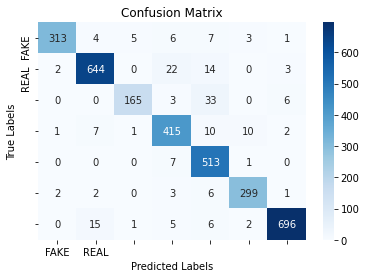

In [ ]:
model = torch.load(output_path + '/model.pth')
model = model.to(device)
evaluate(model, test_iter)

Evaluating 404/405Classification Report:
3236
f1_macro: 0.9598566280955935
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.97      0.98      0.98       685
           2       0.99      0.85      0.91       207
           3       0.95      0.95      0.95       446
           4       0.92      0.99      0.95       521
           5       0.96      0.97      0.97       313
           6       0.99      0.97      0.98       725

    accuracy                           0.97      3236
   macro avg       0.97      0.95      0.96      3236
weighted avg       0.97      0.97      0.97      3236



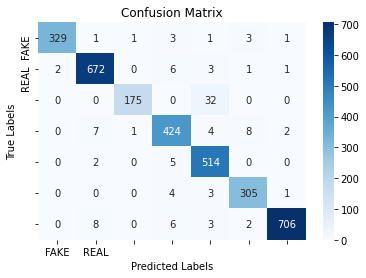

In [ ]:
evaluate(model, test_iter)

Classification Report:
3236
f1_macro: 0.9603900689450445
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.98      0.98      0.98       685
           2       0.99      0.85      0.91       207
           3       0.95      0.96      0.95       446
           4       0.92      0.99      0.95       521
           5       0.96      0.97      0.97       313
           6       0.99      0.98      0.98       725

    accuracy                           0.97      3236
   macro avg       0.97      0.96      0.96      3236
weighted avg       0.97      0.97      0.97      3236



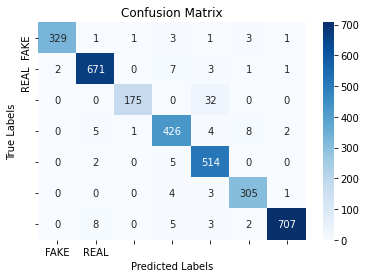

In [ ]:
model = torch.load(output_path + '/model_1616877207.pth')
model = model.to(device)
evaluate(model, test_iter)

Classification Report:
3236
f1_macro: 0.9598566280955935
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       339
           1       0.97      0.98      0.98       685
           2       0.99      0.85      0.91       207
           3       0.95      0.95      0.95       446
           4       0.92      0.99      0.95       521
           5       0.96      0.97      0.97       313
           6       0.99      0.97      0.98       725

    accuracy                           0.97      3236
   macro avg       0.97      0.95      0.96      3236
weighted avg       0.97      0.97      0.97      3236



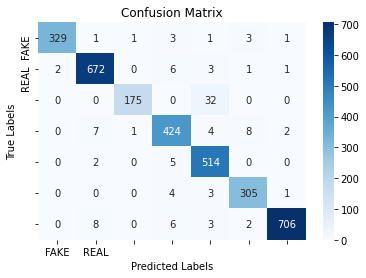

In [ ]:
model = torch.load(output_path + '/model_1616877909.pth')
model = model.to(device)
evaluate(model, test_iter)

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

11324
1617
3236


In [ ]:
import gc
gc.collect()

13288

In [ ]:
import torch
torch.cuda.max_memory_allocated()

0